In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
IMAGE_PATH = "./captured_frames/1_low_far.jpg"

img = cv2.imread(IMAGE_PATH)
if img is None:
    raise FileNotFoundError("Image not found at provided path")

img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

/var/folders/m_/rz6n6w19733dyzctnz643h8c0000gn/T/ipykernel_30914/14295499.py:9: DeprecationWarning: `np.int0` is a deprecated alias for `np.intp`.  (Deprecated NumPy 1.24)
  corners = np.int0(corners)


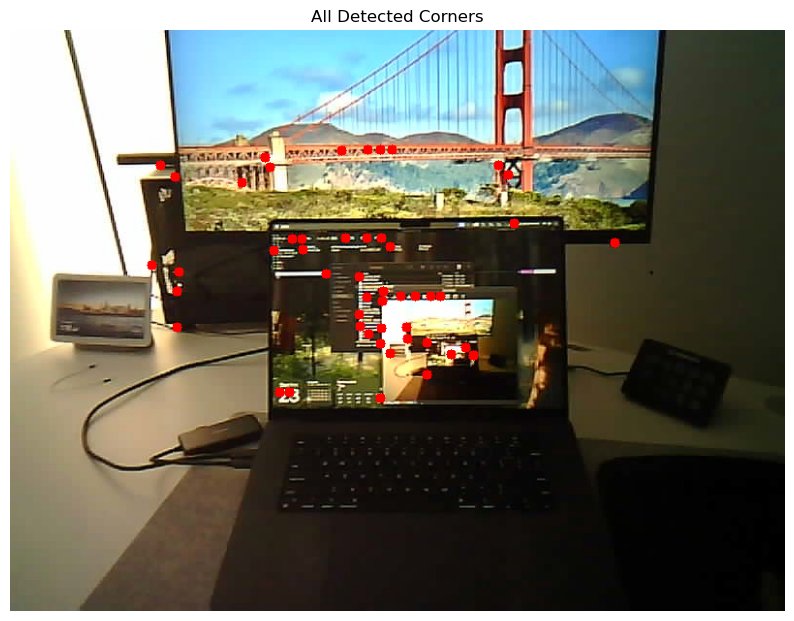

In [2]:
# Shi-Tomasi
corners = cv2.goodFeaturesToTrack(
    gray,
    maxCorners=50,
    qualityLevel=0.04,
    minDistance=10
)

corners = np.int0(corners)

# Zoom window size
ZOOM_SIZE = 40

zoom_plots = []

for i, corner in enumerate(corners):
    x, y = corner.ravel()

    # Draw the detected corner on the main image
    cv2.circle(img_rgb, (x, y), 5, (255, 0, 0), -1)

    # Extract zoom region
    x1 = max(0, x - ZOOM_SIZE)
    x2 = min(gray.shape[1], x + ZOOM_SIZE)
    y1 = max(0, y - ZOOM_SIZE)
    y2 = min(gray.shape[0], y + ZOOM_SIZE)

    zoom_crop = img_rgb[y1:y2, x1:x2]

    # Create enlarged version
    zoom_big = cv2.resize(zoom_crop, None, fx=3, fy=3, interpolation=cv2.INTER_NEAREST)

    zoom_plots.append((f"Corner {i+1}", zoom_big))

plt.figure(figsize=(10, 10))
plt.title("All Detected Corners")
plt.imshow(img_rgb)
plt.axis("off")
plt.show()


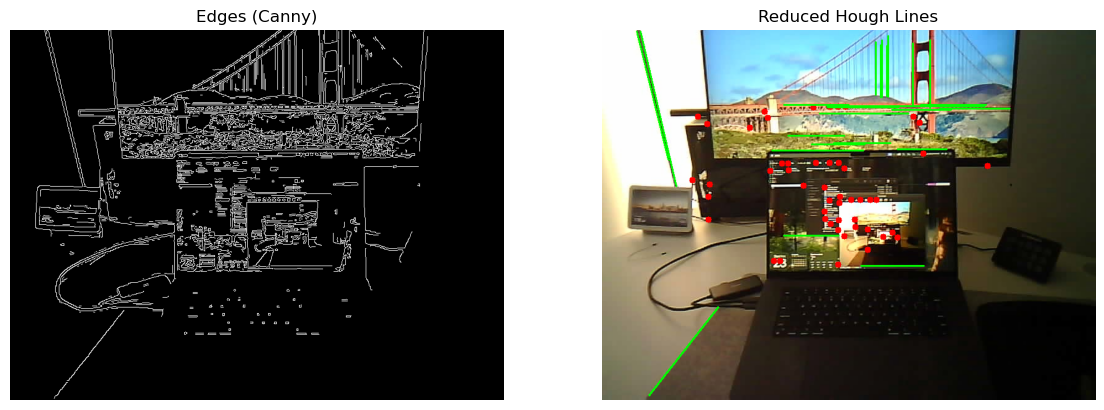

In [3]:
# Edge detection
edges = cv2.Canny(gray, 120, 200)

# HoughLinesP with stricter thresholds (fewer lines)
linesP = cv2.HoughLinesP(
    edges,
    rho = 1,
    theta = np.pi/180,
    threshold = 120,        # ↑ increase to reduce lines
    minLineLength = 80,     # ↑ increase to require longer lines
    maxLineGap = 5          # ↓ decrease to avoid merging
)

hough_img = img_rgb.copy()

if linesP is not None:
    for line in linesP:
        x1, y1, x2, y2 = line[0]
        cv2.line(hough_img, (x1, y1), (x2, y2), (0,255,0), 2)

# Display results
plt.figure(figsize=(14,6))

plt.subplot(1,2,1)
plt.title("Edges (Canny)")
plt.imshow(edges, cmap='gray')
plt.axis("off")

plt.subplot(1,2,2)
plt.title("Reduced Hough Lines")
plt.imshow(hough_img)
plt.axis("off")

plt.show()


In [4]:
# Prepare Hough space
height, width = edges.shape
diag_len = int(np.ceil(np.sqrt(height**2 + width**2)))

rhos = np.linspace(-diag_len, diag_len, diag_len * 2)
thetas = np.deg2rad(np.arange(-90, 90))

accumulator = np.zeros((len(rhos), len(thetas)), dtype=np.uint64)

# Voting in parameter space
y_idxs, x_idxs = np.nonzero(edges)  # edge coordinates

for i in range(len(x_idxs)):
    x = x_idxs[i]
    y = y_idxs[i]

    for t_idx, theta in enumerate(thetas):
        rho = int(x * np.cos(theta) + y * np.sin(theta))
        rho_idx = rho + diag_len   # shift to index space
        accumulator[rho_idx, t_idx] += 1

print("Accumulator shape:", accumulator.shape)


Accumulator shape: (2000, 180)


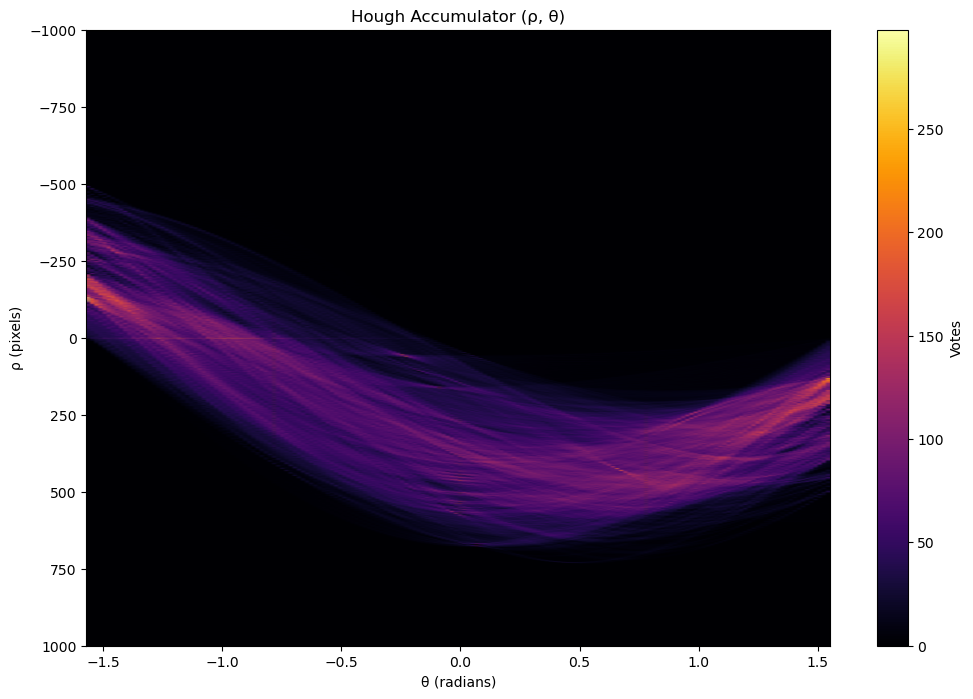

In [5]:
plt.figure(figsize=(12, 8))
plt.title("Hough Accumulator (ρ, θ)")
plt.xlabel("θ (radians)")
plt.ylabel("ρ (pixels)")

plt.imshow(accumulator, cmap="inferno", aspect="auto",
           extent=[thetas[0], thetas[-1], rhos[-1], rhos[0]])

plt.colorbar(label="Votes")
plt.show()


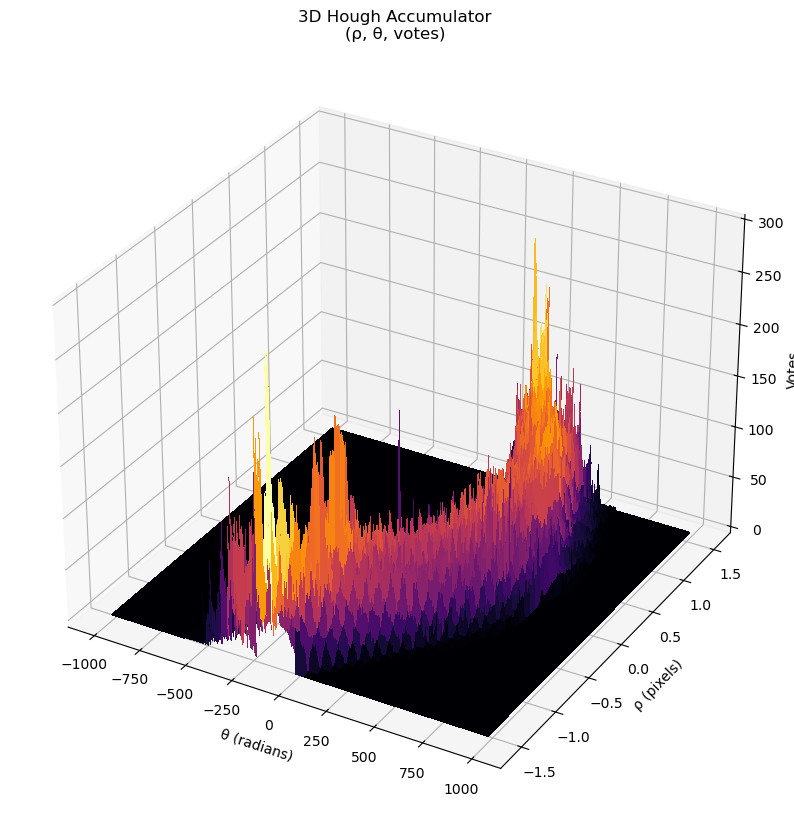

In [6]:
from mpl_toolkits.mplot3d import Axes3D

R, T = np.meshgrid(thetas, rhos)

fig = plt.figure(figsize=(14, 10))
ax = fig.add_subplot(111, projection='3d')

ax.plot_surface(
    T, R, accumulator,
    cmap='inferno',
    linewidth=0,
    antialiased=False
)

ax.set_xlabel("θ (radians)")
ax.set_ylabel("ρ (pixels)")
ax.set_zlabel("Votes")
ax.set_title("3D Hough Accumulator\n(ρ, θ, votes)")

plt.show()
